# Causal Relationship Discovery

## 1. Setup and Data Preparation
This section imports necessary libraries and custom functions for data preprocessing, plotting, causal discovery, and evaluation.


In [1]:
import pandas as pd
import numpy as np
import time

print([np.__version__, pd.__version__])
np.set_printoptions(precision=3, suppress=True)


from src.data_preprocessing import preprocess_data
from src.plotting import plot_time_series, plot_heatmap, plot_causal_graph
from src.causal_matrix_evaluation import evaluate_causal_matrices, interpret_evaluation_metrics
from src.run_causal_discovery import run_varlingam, run_pcmci, run_varlingam_bootstrap
from src.rcv_varlingam import run_rcv_varlingam
from src.rcv_pcmci import run_rcv_pcmci

['1.24.4', '2.0.3']


## 2. Causal Discovery Algorithms and Execution
Here we introduce and execute our causal discovery algorithms to get the correlation matrices and visualise the results.



1. Loading, plotting, and preprocessing data...
Dataset shape: (1000, 5)


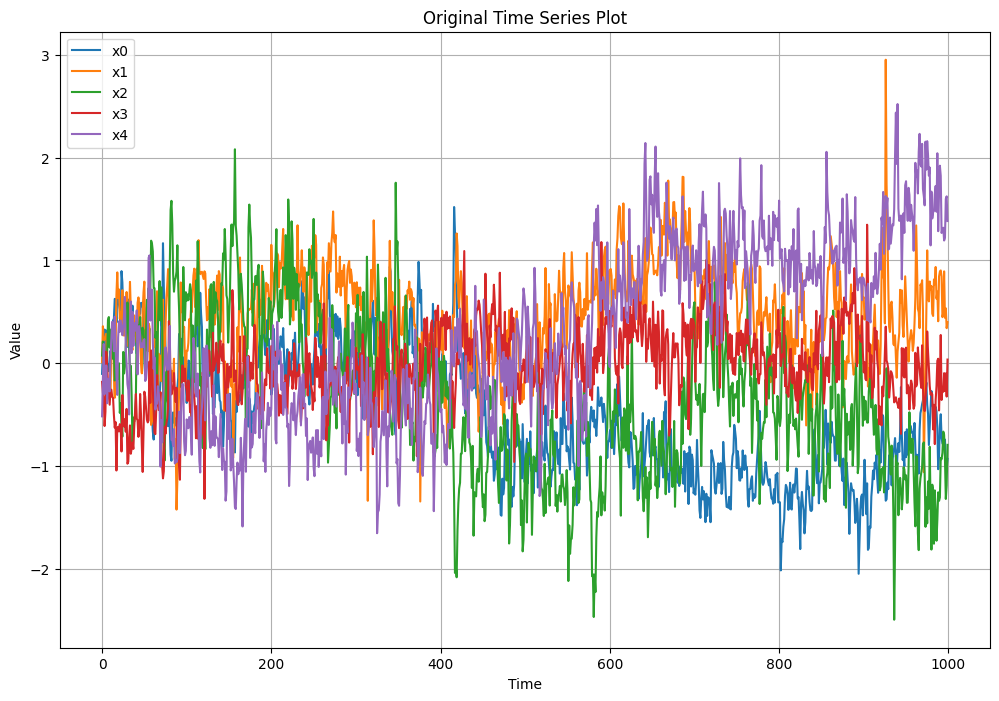


2. Running causal discovery method...

3. Printing results...
Adjacency matrices: [array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.239,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]]), array([[ 0.715,  0.   ,  0.035, -0.253,  0.   ],
       [ 0.   ,  0.722,  0.   , -0.211,  0.   ],
       [ 0.   ,  0.   ,  0.808,  0.229,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.555,  0.   ],
       [ 0.   ,  0.   , -0.293,  0.   ,  0.687]]), array([[0.135, 0.   , 0.   , 0.078, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.157, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.137]])]
Execution time: 0.7387039661407471 seconds

4. Visualizing results...


<Figure size 640x480 with 0 Axes>

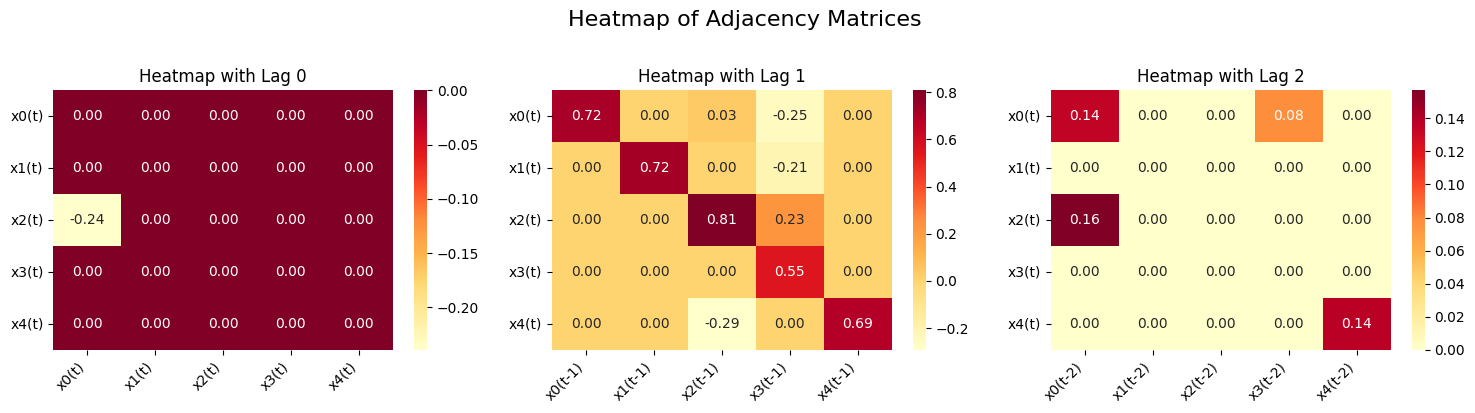

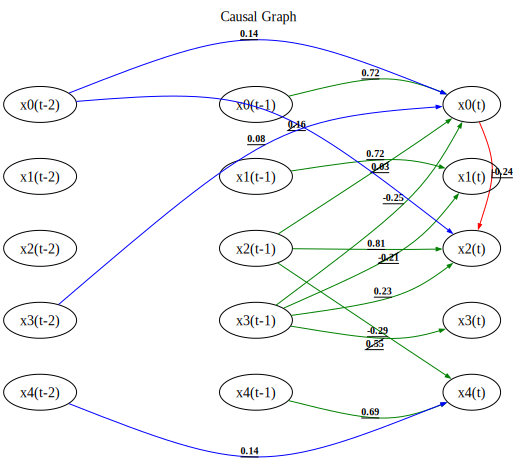

<Figure size 640x480 with 0 Axes>

In [2]:
# 1. Load, plot, and preprocess data
print("\n1. Loading, plotting, and preprocessing data...")
data = pd.read_csv('data/synthetic/scale_5_var/dataset_0.csv')
columns = data.columns.tolist()
if "Date" in columns:
    data = data.drop(['Date'], axis=1).values
    columns.remove('Date')
else:
    data = data.values
print("Dataset shape:", data.shape)

# Plot original time series
plot_time_series(data, columns, title="Original Time Series Plot")

# Preprocess data
data = preprocess_data(data, columns)

# 2. Run causal discovery method
print("\n2. Running causal discovery method...")
method = "rcv_varlingam"  # Choose from: 'varlingam', 'pcmci', 'varlingam_bootstrap', 'rcv_varlingam', 'rcv_pcmci'

start_time = time.time()

if method == 'varlingam':
    results = run_varlingam(data, lags=1)
    adjacency_matrices = results.adjacency_matrices_
elif method == 'pcmci':
    adjacency_matrices = run_pcmci(data)
elif method == 'varlingam_bootstrap':
    adjacency_matrices = run_varlingam_bootstrap(data, lags=5, n_sampling=10, variance_threshold=0.1, occurrence_threshold=0.6)
elif method == 'rcv_varlingam':
    adjacency_matrices = run_rcv_varlingam(data, n_splits=7, consistency_threshold=0.7, variability_threshold=0.4, adjustment_weight=0.1)
elif method == 'rcv_pcmci':
    adjacency_matrices = run_rcv_pcmci(data, n_splits=3, consistency_threshold=0.1, variability_threshold=0.1, adjustment_weight=0.1)
else:
    print("Invalid method chosen")
    exit()

end_time = time.time()

# 3. Print results and execution time
print("\n3. Printing results...")
print("Adjacency matrices:", adjacency_matrices)
print(f"Execution time: {end_time - start_time} seconds")

# 4. Visualize results
print("\n4. Visualizing results...")
plot_heatmap(adjacency_matrices, columns)
causal_graph = plot_causal_graph(adjacency_matrices, node_labels=columns)
display(causal_graph)

## 3. Model Evaluation 
This section focuses on evaluating our causal discovery algorithms using frobenius norm, structural hamming distance, and precision-recall metrics.

In [3]:
def ground_truth_to_matrices(csv_path):
    # Read the CSV file
    with open(csv_path, 'r') as f:
        content = f.read()

    # Split the content by double newlines to separate matrices
    matrix_strings = content.strip().split('\n\n')
    
    # Convert each matrix string to a numpy array
    matrices = []
    for matrix_string in matrix_strings:
        matrix = np.array([list(map(float, row.split(','))) for row in matrix_string.split('\n')])
        matrices.append(matrix)
    
    return matrices

# Function to load ground truth
def load_ground_truth():
    ground_truth_path = f'data/synthetic/scale_5_var/ground_truth.csv'
    try:
        return ground_truth_to_matrices(ground_truth_path)
    except FileNotFoundError:
        print(f"Ground truth file not found: {ground_truth_path}")
        return None


Evaluating causal discovery results...

Causal Discovery Evaluation Results:
[Structural Hamming Distance] Good: 5 (35.71%). Some structural differences.
[f1] Good: 0.800. Good accuracy in identifying causal relationships.
[F1→] Good: 0.800. Good accuracy in identifying directed causal relationships.
[Frobenius Norm] Good: 0.561. Reasonable match between true and estimated matrices.
[lags] Overestimation: Estimated 3 lags, with 1 extra lags.

6. Visualizing comparison...


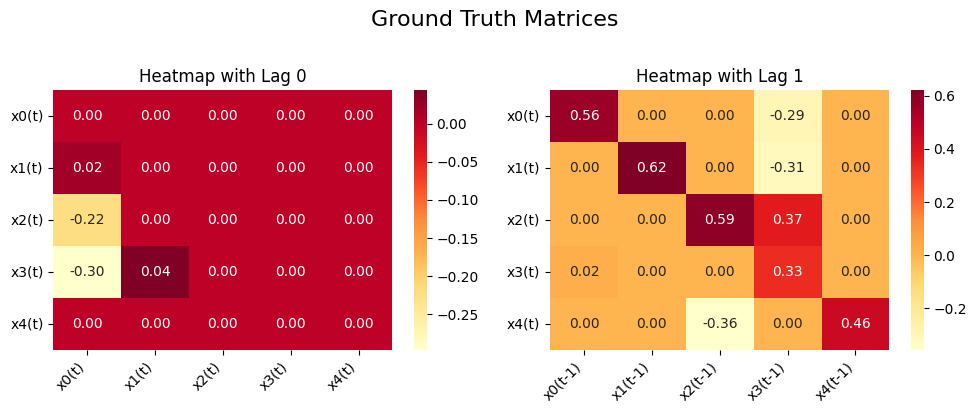

<Figure size 640x480 with 0 Axes>

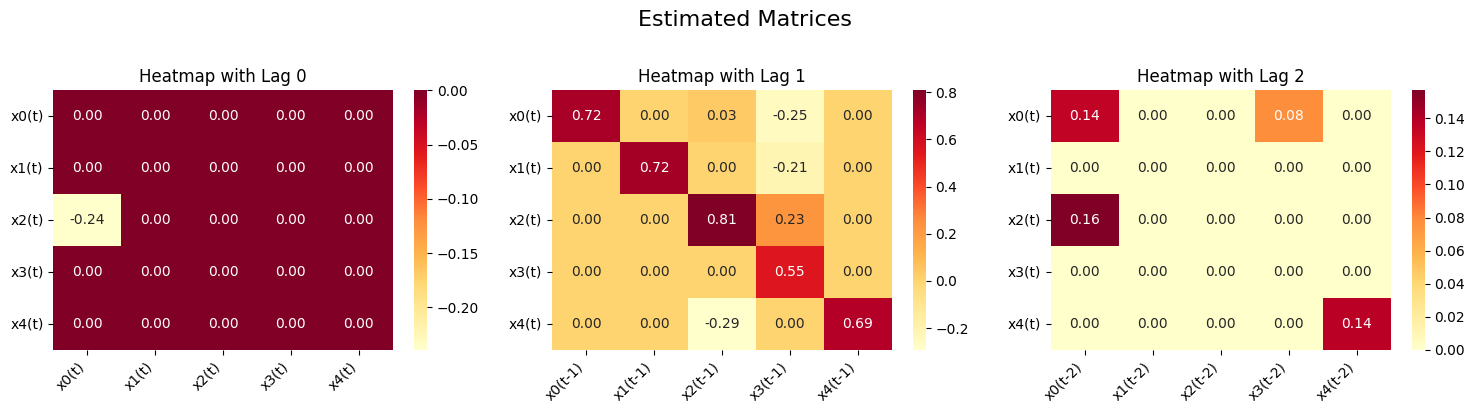

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
print("\nEvaluating causal discovery results...")
ground_truth_matrices = load_ground_truth()

# Evaluate causal discovery results
print("\nCausal Discovery Evaluation Results:")
evaluation_results = evaluate_causal_matrices(ground_truth_matrices, adjacency_matrices)
result_interpretations = interpret_evaluation_metrics(evaluation_results)

# Print evaluation results
for metric, interpretation in result_interpretations.items():
    print(f"[{metric}] {interpretation}")

# 6. Visualize comparison (optional)
print("\n6. Visualizing comparison...")
plot_heatmap(ground_truth_matrices, columns, title="Ground Truth Matrices")
plot_heatmap(adjacency_matrices, columns, title="Estimated Matrices")